In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## MSOA data

In this notebook, I am reconstructing the MSOA dataset to check for any errors, and any mismatching keys on merging etc.

This notebook is the corrected version. Previous versions will be removed.


Features:
1. Income
2. Houseprice
3. Electricity consumption
4. Index of multiple deprivation decile
5. Rural-urban classification (cat)
6. Solar panel count (transient)
7. Public EV charger count (transient)
8. Private EV charger count (transient)
9. Average EV price (transient)
10. EV count (transient) <- variable to predict



### 1. Income

In [2]:
# load income and just keep most recent
df = pd.read_csv('msoa_annual_income.csv',index_col=0)
df = df[['MSOA_code','total_annual_income_2019']]

In [3]:
df.shape

(7201, 2)

### 2. Houseprice

In [4]:
df1 = pd.read_csv('data/msoa_houseprice.csv',index_col=0)
df1.head()

,MSOA11CD,houseprice_avg_2019
0,E02000001,806491.623740
1,E02000002,357206.000000
2,E02000003,356416.666667
3,E02000004,342250.000000
4,E02000005,326500.000000


In [5]:
df.head()

,MSOA_code,total_annual_income_2019
0,E02004297,40650.0
1,E02004290,43260.0
2,E02004298,40635.0
3,E02004299,34450.0
4,E02004291,34730.0


In [6]:
df = df.merge(df1, left_on ='MSOA_code', right_on='MSOA11CD')
df = df[['MSOA11CD', 'total_annual_income_2019','houseprice_avg_2019']]
df.head()

,MSOA11CD,total_annual_income_2019,houseprice_avg_2019
0,E02004297,40650.0,129990.000000
1,E02004290,43260.0,135343.750000
2,E02004298,40635.0,136866.666667
3,E02004299,34450.0,109200.000000
4,E02004291,34730.0,95375.000000


### 3. Index of Multiple Deprivation

In [7]:
df1 = pd.read_csv('data/msoa_imd.csv')

In [8]:
df = df.merge(df1, on='MSOA11CD')
df.head()

,MSOA11CD,total_annual_income_2019,houseprice_avg_2019,IMDRank,IMDDecil
0,E02004297,40650.0,129990.000000,20450.20,6.0
1,E02004290,43260.0,135343.750000,21972.50,8.0
2,E02004298,40635.0,136866.666667,18949.50,6.5
3,E02004299,34450.0,109200.000000,10635.60,4.0
4,E02004291,34730.0,95375.000000,7844.25,2.5


### 4. RUC

In [9]:
df1 = pd.read_csv('data/msoa_ruc.csv')

In [10]:
df = df.merge(df1, on='MSOA11CD')
df.head()

,MSOA11CD,total_annual_income_2019,houseprice_avg_2019,IMDRank,IMDDecil,RUC11
0,E02004297,40650.0,129990.000000,20450.20,6.0,Rural town and fringe
1,E02004290,43260.0,135343.750000,21972.50,8.0,Urban major conurbation
2,E02004298,40635.0,136866.666667,18949.50,6.5,Urban city and town
3,E02004299,34450.0,109200.000000,10635.60,4.0,Urban city and town
4,E02004291,34730.0,95375.000000,7844.25,2.5,Urban major conurbation


### 5. (T) EV count (target variable)

(T) for transient variables.

MOT data. So select only MSOA with MOT centres.

In [11]:
df1 = pd.read_csv('data/msoa_ev_count_dated.csv')
df1.set_index('msoa11cd', inplace=True)
for col in df1.columns:
    df1.rename(columns={col:col[:7]},inplace=True)
#df1 = df1[['index','2021-04']]
#df1.rename(columns={'index':'MSOA11CD', '2021-04':'ev_count_2021'}, inplace=True)
df1 = df1[df1.columns.sort_values()]
df1 = df1[df1.columns[-88:]]

In [12]:
df_mot = pd.read_csv('data/mot_locations_lsoa_msoa_pcd.csv')
msoa_to_keep = df_mot.msoa11cd.unique()

In [13]:
df1.reset_index(inplace=True)
df1 = df1[df1['msoa11cd'].isin(msoa_to_keep)]

In [14]:
# pad missing msoas with zeros

print(len(msoa_to_keep))
print(df1.msoa11cd.nunique())

missing_msoa = list(set(msoa_to_keep) - set(df1.msoa11cd.unique()))

#df1.set_index(['msoa11cd'],inplace=True)
# store the dates
columns_names = df1.columns.values

# for each msoa add a row of zeros
df_missing_msoa = pd.DataFrame(columns=columns_names)
for i in range(len(missing_msoa)):
    df_missing_msoa = df_missing_msoa.append(pd.Series({"msoa11cd": missing_msoa[i],
                         columns_names[2]: 0}),ignore_index=True)
df_missing_msoa.fillna(0,inplace=True)

df1= df1.append(df_missing_msoa)
df1.reset_index(drop=True)
print(df1.shape)
print(df1.msoa11cd.nunique())

5740
4392
(5740, 89)
5740


In [15]:
df = df.merge(df1[['msoa11cd','2021-04']], left_on='MSOA11CD', right_on='msoa11cd')

In [16]:
df.rename(columns={'2021-04':'ev_count'},inplace=True)
print(df.shape)
df.head()

(5740, 8)


,MSOA11CD,total_annual_income_2019,houseprice_avg_2019,IMDRank,IMDDecil,RUC11,msoa11cd,ev_count
0,E02004297,40650.0,129990.000000,20450.20,6.0,Rural town and fringe,E02004297,2
1,E02004290,43260.0,135343.750000,21972.50,8.0,Urban major conurbation,E02004290,1
2,E02004298,40635.0,136866.666667,18949.50,6.5,Urban city and town,E02004298,4
3,E02004299,34450.0,109200.000000,10635.60,4.0,Urban city and town,E02004299,1
4,E02004291,34730.0,95375.000000,7844.25,2.5,Urban major conurbation,E02004291,0


### 6. (T) PV count

In [17]:
df1 = pd.read_csv('data/pv_msoa_fit_timeseries.csv',index_col=0)
df1.reset_index(level=0, inplace=True)
df1.rename(columns={'MLSOA Code':'MSOA11CD','2020-03':'pv_count_2020'},inplace=True)
df1 = df1[['MSOA11CD','pv_count_2020']]
print(df.shape)
df1.head()

(5740, 8)


,MSOA11CD,pv_count_2020
0,E02000001,1
1,E02000002,17
2,E02000003,10
3,E02000004,6
4,E02000005,73


In [18]:
# Need to pad pv data
list(set(msoa_to_keep) - set(df1.MSOA11CD.unique()))

missing_msoa = list(set(msoa_to_keep) - set(df1.MSOA11CD.unique()))

#df1.set_index(['msoa11cd'],inplace=True)
# store the dates
columns_names = df1.columns.values

# for each msoa add a row of zeros
df_missing_msoa = pd.DataFrame(columns=columns_names)
for i in range(len(missing_msoa)):
    df_missing_msoa = df_missing_msoa.append(pd.Series({"MSOA11CD": missing_msoa[i],
                         columns_names[1]: 0}),ignore_index=True)
df_missing_msoa.fillna(0,inplace=True)

df1= df1.append(df_missing_msoa)
df1.reset_index(drop=True)

df1 = df1[df1['MSOA11CD'].isin(msoa_to_keep)]

print(df1.shape)
print(df1.MSOA11CD.nunique())


(5740, 2)
5740


In [19]:
df = df.merge(df1, on='MSOA11CD')
print(df.shape)
df.head()

(5740, 9)


,MSOA11CD,total_annual_income_2019,houseprice_avg_2019,IMDRank,IMDDecil,RUC11,msoa11cd,ev_count,pv_count_2020
0,E02004297,40650.0,129990.000000,20450.20,6.0,Rural town and fringe,E02004297,2,41
1,E02004290,43260.0,135343.750000,21972.50,8.0,Urban major conurbation,E02004290,1,70
2,E02004298,40635.0,136866.666667,18949.50,6.5,Urban city and town,E02004298,4,111
3,E02004299,34450.0,109200.000000,10635.60,4.0,Urban city and town,E02004299,1,50
4,E02004291,34730.0,95375.000000,7844.25,2.5,Urban major conurbation,E02004291,0,35


### 7. (T) Public EV chargers


In [20]:
df1 = pd.read_csv('data/public_chargers_msoa_timeseries.csv')
df1 = df1[['MSOA11CD','04-2021_msoa']]
df1.rename(columns={'04-2021_msoa':'public_chargers_2021'}, inplace=True)
print(df1.shape)
df1.head()

(8480, 2)


,MSOA11CD,public_chargers_2021
0,E02004296,11.090909
1,E02004302,11.090909
2,E02004305,11.090909
3,E02004303,11.090909
4,E02004301,11.090909


In [21]:
df = df.merge(df1, on='MSOA11CD', how='inner')
print(df.shape)

(5740, 10)


In [22]:
df.head()

,MSOA11CD,total_annual_income_2019,houseprice_avg_2019,IMDRank,IMDDecil,RUC11,msoa11cd,ev_count,pv_count_2020,public_chargers_2021
0,E02004297,40650.0,129990.000000,20450.20,6.0,Rural town and fringe,E02004297,2,41,11.090909
1,E02004290,43260.0,135343.750000,21972.50,8.0,Urban major conurbation,E02004290,1,70,11.090909
2,E02004298,40635.0,136866.666667,18949.50,6.5,Urban city and town,E02004298,4,111,11.090909
3,E02004299,34450.0,109200.000000,10635.60,4.0,Urban city and town,E02004299,1,50,11.090909
4,E02004291,34730.0,95375.000000,7844.25,2.5,Urban major conurbation,E02004291,0,35,11.090909


### 8. (T) Private EV chargers


In [23]:
df1 = pd.read_csv('data/private_chargers_msoa_timeseries.csv')
df1 = df1[['MSOA11CD','2021_msoa']]
df1.rename(columns={'2021_msoa':'private_chargers_2021'},inplace=True)
df1.shape

(8480, 2)

In [24]:
df = df.merge(df1, on='MSOA11CD', how='inner')
df.shape

(5740, 11)

### 9. (T) Energy consumption

In [25]:
df1 = pd.read_csv('data/msoa_mean_electricity_consumption_timeseries.csv')
df1.drop_duplicates(inplace=True)
print(df1[df1['MSOA11CD'].isin(msoa_to_keep)].shape)
df1.head()

(5740, 11)


,MSOA11CD,elec_consumption_2010,elec_consumption_2011,elec_consumption_2012,elec_consumption_2013,elec_consumption_2014,elec_consumption_2015,elec_consumption_2016,elec_consumption_2017,elec_consumption_2018,elec_consumption_2019
0,E02000001,26458.293591,25895.167020,26093.384011,24627.950252,25039.841127,24638.174609,23537.531635,24252.918174,23452.901927,22663.177680
6,E02000002,14296.151606,14204.053407,13942.902984,13895.918558,13793.610177,13494.474645,13236.229927,13010.165579,12729.403475,12874.224118
10,E02000003,25539.505938,24467.566581,24300.180044,23637.697618,23761.015832,22992.266592,22709.373297,22052.283045,21534.673770,21263.312685
16,E02000004,16138.634054,16315.131633,15903.536809,15656.571828,15584.837347,15394.535534,15107.126299,14613.766531,14215.805846,14137.843118
20,E02000005,18817.163145,18777.858282,18691.488157,18417.020594,18215.420095,17859.547178,17284.724543,16718.143903,15930.663440,15896.856920


In [26]:
df = df.merge(df1[['MSOA11CD','elec_consumption_2019']], on='MSOA11CD')
df.shape

(5740, 12)

### 10. (T) EV Price

## Check for correlations

In [27]:
df.set_index('MSOA11CD', inplace=True)

In [28]:
df.columns

Index(['total_annual_income_2019', 'houseprice_avg_2019', 'IMDRank',
       'IMDDecil', 'RUC11', 'msoa11cd', 'ev_count', 'pv_count_2020',
       'public_chargers_2021', 'private_chargers_2021',
       'elec_consumption_2019'],
      dtype='object')

In [29]:
numeric_features = ['total_annual_income_2019', 'houseprice_avg_2019', 'IMDRank',
       'IMDDecil','ev_count', 'pv_count_2020',
       'public_chargers_2021', 'private_chargers_2021']

<AxesSubplot:>

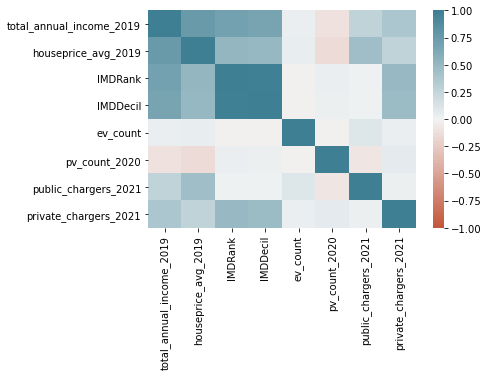

In [31]:
sns.heatmap(df[numeric_features].corr(), vmin=-1, vmax=1, cmap=sns.diverging_palette(20,220,n=200))

Select MSOAs for which there are MOT centres present.

Save the file as MSOA info today

In [ ]:
df1 = pd.read_csv('data/mot_locations_lsoa_msoa_pcd.csv')
print(df1.shape)
df1.head()

In [ ]:
msoa_to_keep = df1.msoa11cd.unique()

In [ ]:
df.reset_index(inplace=True)

In [ ]:
df = df[df['MSOA11CD'].isin(msoa_to_keep)]

In [ ]:
df.head()

In [32]:
#df.to_csv('data/msoa_today_steady.csv')

In [33]:
#df.shape

(5740, 11)

In [34]:
df[df['ev_count']>0].shape

(4392, 11)